# Time series and SVD
- Testing out time series forecasting using SVD via time-delay embedding matrix (this can handle missing values naturally)
- Testing out downsampling method using SVD (by choosing latent "user" matrix) for persistent homology calculations

In [21]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession, DataFrame
from pyspark.sql.functions import col, split, regexp_replace, explode
from pyspark.sql.types import ArrayType, StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import array, struct
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import coalesce, col, datediff, lag, lit, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import array
from pyspark.sql import functions

# data
import numpy as np
import pandas as pd
import time
from scipy import stats
from scipy.special import binom
from scipy.spatial import distance_matrix
import itertools
import math
from db import DB
import datetime
from ast import literal_eval
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from matplotlib import collections  as mc
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

# dionysus
import dionysus as d

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [9]:
def desc(df):
    display(df.head())
    print(df.shape)
    print(df.dtypes)

In [175]:
def flatten_two_level_df_cols(df, sep='_'):
    df.columns = [sep.join((str(tpl[0]), str(tpl[1]))) for tpl in zip(df.columns.get_level_values(0), df.columns.get_level_values(1))]
    return df

In [18]:
def simplex_conditions(row, columns, n):
    '''
    Helper function to apply conditions that single 
    out a simplex. To be used applied to a pandas DataFrame.
    The columns are assumed to be {1, 2,..., n, (1, 2), (1, 3), ...} where 
    n is the dimension of simplex being checked for. The columns 1, ..., n
    are assumed to be integer type and the columns of the form (i, j) are 
    assumed to be tuple type, and to have i < j.
    
    Parameters:
    - row: row of the DataFrame
    - columns: list of the columns of the DataFrame
    - n: dimnesion of the simplex being checked for
    
    Returns:
    - Boolean based on whether the row in question satisfies simplex conditions
    '''
    
    for col in columns:
        if type(col) == int and col < n:
            if row[col] == row[col+1]:
                return False
            
        elif type(col) == tuple:
            if row[col[1]] != row[col]:
                return False
            
    else:
        return True  

In [19]:
def create_n_simplexes(one_spxs, n):
    '''
    Helper function that creates an array of the 
    n simplexes from the data frame of the 
    one simplexes
    
    Parameters:
    - one_spxs: DataFrame of one simplexes 
    - n: dimension of simplexes being created
    
    Returns:
    - list of n+1-tuples that represent n simplexes
    '''
    
    # create copy of one simplexes
    df = one_spxs
    
    # iteratively merge on one simplexes
    for combo in list(itertools.combinations(range(n+1), 2))[1:]:
        if combo[0] == 0:
            df = pd.merge(
                left=df,
                right=one_spxs.rename(columns={1: combo[1]}),
                on=0,
                how='left'
            ).dropna().drop_duplicates().astype(int)
        else:
            df = pd.merge(
                left=df,
                right=one_spxs.rename(columns={0: combo[0], 1: combo}),
                on=combo[0],
                how='left'
            ).dropna().drop_duplicates().astype(int)
    
    # extract vertexes that make up the n simplexes
    cols = df.columns

    n_simplexes = []
    if len(df) > 0:
        n_simplexes = [tuple(simplex) for simplex in df[df.apply(lambda x: simplex_conditions(x, cols, n), axis=1)][[col for col in df.columns if type(col) == int]].values]
    
    return n_simplexes

In [20]:
def plot_two_simplexes(point_cloud, distance_matrix, epsilon, one_simplexes_color='#6DA5BA', two_simplexes_color='#E0513B'):
    one_simplicies = [(x,y) for (x,y) in zip(*np.where(distance_matrix <= epsilon)) if x < y]
    two_simplicies = create_n_simplexes(one_spxs=pd.DataFrame(one_simplicies), n=2)

    lines = [(point_cloud[x], point_cloud[y]) for (x, y) in one_simplicies]

    fig, ax = plt.subplots(figsize=(7, 7))

    lc2 = mc.LineCollection(
        lines,
        colors=one_simplexes_color,
        linewidths=0.5
    );

    pd.DataFrame(point_cloud).rename(columns={0: 'x', 1: 'y'}).plot(
        kind='scatter',
        x='x',
        y='y',
        ax=ax,
        s=7,
        c=one_simplexes_color
    );

    ax.add_collection(lc2);
    ax.autoscale();

    for two_simplex in two_simplicies:
        Path = mpath.Path
        path_data = [
                (Path.MOVETO, point_cloud[two_simplex[0]]),
                (Path.LINETO, point_cloud[two_simplex[1]]),
                (Path.LINETO, point_cloud[two_simplex[2]]),
                (Path.CLOSEPOLY, point_cloud[two_simplex[0]]),
                ]
        codes, verts = zip(*path_data)
        path = mpath.Path(verts, codes)
        patch = mpatches.PathPatch(path, facecolor=two_simplexes_color, alpha=0.2);
        ax.add_patch(patch);

    plt.show();

In [10]:
def rolling_window(a, window):
    '''
    Take in an array and return array of rolling windows of specified length
    
    Parameters:
    - a: numpy array that will be windowed
    - window: integer that will be the length of the window
    
    Returns:
    - a_windowed: array where each entry is an array of length window
    '''
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    a_windowed = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return a_windowed

In [11]:
def time_series_to_point_cloud(time_series, dimension_embed=2):
    '''
    Convert a time series into a point cloud in the dimension specified by dimension_embed
    
    Parameters:
    - time_series: numpy array of time series values
    - dimension_embed: dimension of Euclidean space in which to embed the time series into by taking windows of dimension_embed length,
        e.g. if the time series is [t_1,...,t_n] and dimension_embed is 2, then the point cloud would be [(t_0, t_1), (t_1, t_2),...,(t_(n-1), t_n)]
        
    Returns:
    - point_cloud_normalized: point cloud normalized to take values between [0, 1]
    '''

    assert len(time_series) >= dimension_embed, 'dimension_embed larger than length of time_series'
    
    # time series to float type
    time_series = np.array(time_series)
    time_series = time_series.astype(float)

    # compute point cloud
    point_cloud = rolling_window(a=time_series, window=dimension_embed)
    
    return np.array(point_cloud)

In [12]:
def point_cloud_to_persistent_homology(point_cloud, epsilon_range, max_simplex_dim):
#     print(point_cloud)
#     epsilon_range = literal_eval(epsilon_range)
    epsilon_range = np.array(epsilon_range)
    
#     point_cloud = literal_eval(point_cloud)
    point_cloud = np.array(point_cloud)
    
    # take unique points in the point cloud only
#     point_cloud = np.unique(point_cloud, axis=0)
    point_cloud = [list(x) for x in set(tuple(x) for x in point_cloud)]
    
    # compute distance matrix
    distance_mtx = distance_matrix(x=point_cloud, y=point_cloud, p=2)
    
    # find max distance between points
    max_distance = distance_mtx.max()
    
    # scale epsilon_range
    epsilon_range = epsilon_range*(max_distance**2)

    # build filtration with fill_rips
    filtration = d.fill_rips(np.array(point_cloud), k=max_simplex_dim, r=max_distance**2)
    
    # calculate persistent homology
    persistence = d.homology_persistence(filtration)
    
    # initialize persistence diagrams
    diagrams = d.init_diagrams(persistence, filtration)
    
    ep_ran_len = len(epsilon_range)
    
    homology = {dimension: np.zeros(ep_ran_len).tolist() for dimension in range(max_simplex_dim)}

    for dimension, diagram in enumerate(diagrams):
        if dimension < max_simplex_dim and len(diagram) > 0:
            homology[dimension] = np.array([np.array(((epsilon_range >= point.birth) & (epsilon_range <= point.death)).astype(int)) 
                                        for point in diagram
                                       ]).sum(axis=0).tolist()
        
    return homology

In [6]:
def create_n_simplexes(one_spxs, n):
    '''
    Helper function that creates an array of the 
    n simplexes from the data frame of the 
    one simplexes
    
    Parameters:
    - one_spxs: DataFrame of one simplexes 
    - n: dimension of simplexes being created
    
    Returns:
    - list of n+1-tuples that represent n simplexes
    '''
    
    # create copy of one simplexes
    df = one_spxs
    
    # iteratively merge on one simplexes
    for combo in list(itertools.combinations(range(n+1), 2))[1:]:
        if combo[0] == 0:
            df = pd.merge(
                left=df,
                right=one_spxs.rename(columns={1: combo[1]}),
                on=0,
                how='left'
            ).dropna().drop_duplicates().astype(int)
        else:
            df = pd.merge(
                left=df,
                right=one_spxs.rename(columns={0: combo[0], 1: combo}),
                on=combo[0],
                how='left'
            ).dropna().drop_duplicates().astype(int)
    
    # extract vertexes that make up the n simplexes
    cols = df.columns

    n_simplexes = []
    if len(df) > 0:
        n_simplexes = [tuple(simplex) for simplex in df[df.apply(lambda x: simplex_conditions(x, cols, n), axis=1)][[col for col in df.columns if type(col) == int]].values]
    
    return n_simplexes

In [13]:
def time_series_to_persistent_homology(time_series, epsilon_range, max_simplex_dim):
    '''
    Wrapper function that takes in a time series and outputs
    the persistent homology object, along with other
    auxiliary objects.
    
    Parameters: 
    - time_series: Numpy array of time series values
    - num_epsilon_steps: Either a positive integer or a list of epsilon values. If an integer, it is the number of segments the inverval [0, 1] 
    will be divided into. The method parameter will determine how the division will be set.
    - max_simplex_dim: Integer denoting the maximum dimension of simplexes to create in filtration
    
    Returns:
    '''
    
    # create point cloud from time series
    point_cloud = time_series_to_point_cloud(time_series, dimension_embed=max_simplex_dim)

    homology = point_cloud_to_persistent_homology(point_cloud=point_cloud, epsilon_range=epsilon_range, max_simplex_dim=max_simplex_dim)
    return homology

In [14]:
def betti(time_series, epsilon_range, max_simplex_dim, agg=None):
    homology = time_series_to_persistent_homology(time_series=time_series,
                                                  epsilon_range=epsilon_range,
                                                  max_simplex_dim=max_simplex_dim)
    
    if agg == 'sum':
        return np.array(homology.values()).sum().sum()
    elif agg == 'mean':
#         return np.array(homology.values()).mean()
        return np.array(homology.values()).mean(axis=1).sum()
    elif agg == 'median':
        return np.median(np.array(homology.values()))
    else:
        return np.array(homology.values())

In [15]:
def time_series_rolling_betti(time_series, epsilon_range, max_simplex_dim, window, agg=None):
    '''
    Parameters:
    - time_series: pandas Series
    - epsilon_range: numpy array
    - max_simplex_dim: int
    - window: int
    - agg: string or None. If string, one of 'sum', 'mean', or 'median'
    '''
    betti_results = [betti(time_series=wdw,
                       epsilon_range=epsilon_range,
                       max_simplex_dim=max_simplex_dim,
                       agg=agg) for wdw in rolling_window(time_series, window)]
    
    return pd.concat([time_series, pd.Series(data=betti_results, index=time_series.index[window-1:], name='betti')], axis=1)

In [16]:
def compute_persistent_homology_df(df, value_col, date_col, index_col, epsilon_range, max_simplex_dim, window):
    # compute rolling betti matrix
    bt_mtx = time_series_rolling_betti(
        time_series=df.sort_values(date_col, ascending=True)[value_col],
        epsilon_range=epsilon_range,
        max_simplex_dim=max_simplex_dim,
        window=window,
        agg=None
    )
    
    # add betti matrix column, being careful with the index
    df.loc[df.index,'betti'] = pd.Series(data=bt_mtx['betti'].values, index=df.index)
    
    # drop nulls that arise from windowing
    df.dropna(inplace=True)
    
    print(df.iloc[0][index_col], len(df))
    
    # separate out dimensions of betti matrix
    for dim in range(max_simplex_dim):
        print(len(df['betti'].apply(lambda x: x[dim])))
        df['betti_'+str(dim)] = df['betti'].apply(lambda x: x[dim])
    
    # create list that will be turned into data frame
    # this is the equivalent of 'exploding' (a la SQL) the lists in
    # the betti column
    rows = []
    _ = df.apply(lambda row: [rows.append([
        row[index_col],
        row[date_col],
        row[value_col]
    ]+list(tpl)) for tpl in list(zip(*( [row['betti_{DIM}'.format(DIM=dim)] for dim in range(max_simplex_dim) ] + [epsilon_range] ))) ], axis=1)
    
    df_new = pd.DataFrame(
        rows, 
        columns=[index_col, date_col, value_col] + ['betti_{DIM}'.format(DIM=dim) for dim in range(max_simplex_dim)] + ['epsilon']
    )
    
    return df_new

In [17]:
def noisy_sine(n_steps, radial_noise, amp_noise):
    return np.sin([(16*np.pi*x + radial_noise*random.random())/(n_steps) + amp_noise*random.random() for x in range(n_steps)])

# Time series forecasting with SVD

## Noisy Sine

In [346]:
n_steps = 1000
rrand = 50
alpha = 0.5

ts = np.sin([(16*np.pi*x + rrand*random.random())/(n_steps) + alpha*random.random() for x in range(n_steps)])

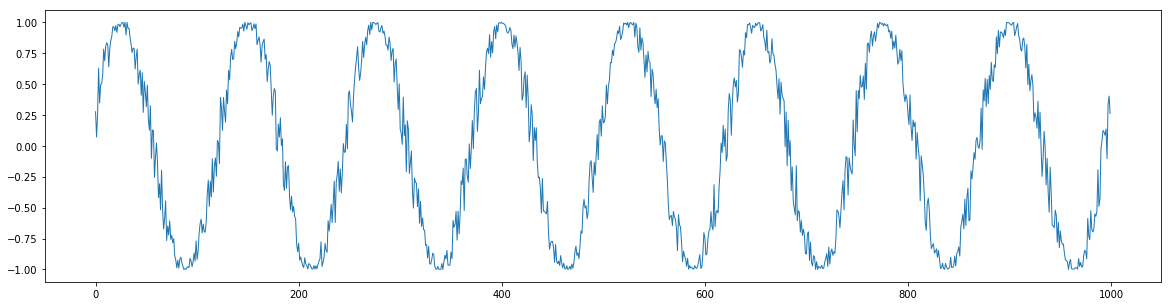

In [347]:
pd.DataFrame(ts).plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    legend=False
);

In [402]:
ts_embed_unstack = pd.DataFrame([ts[i:i+200] for i in range(len(ts)-99)])

In [403]:
ts_embed_unstack

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.276427,0.072174,0.256424,0.628079,0.347457,0.495781,0.503613,0.572379,0.782882,0.688181,0.807255,0.834534,0.817212,0.639331,0.789097,0.851510,0.888529,0.964732,0.963343,0.932179,0.973293,0.918972,0.982073,0.984922,0.965585,0.981682,0.997642,0.999989,0.959834,0.999982,0.898438,0.999856,0.952106,0.951604,0.876674,0.820669,0.755704,0.791338,0.789336,0.622962,0.720940,0.783538,0.499983,0.580456,0.612220,0.409616,0.592466,0.271864,0.522874,0.440251,0.317925,0.491557,0.218805,0.126333,0.324552,-0.101285,0.128684,0.123415,-0.254505,-0.093228,0.024545,-0.134629,-0.418045,-0.306185,-0.516855,-0.196803,-0.510360,-0.672347,-0.589690,-0.445288,-0.765751,-0.648848,-0.721081,-0.606815,-0.755780,-0.723238,-0.784770,-0.751432,-0.890229,-0.924341,-0.986683,-0.926365,-0.988703,-0.917234,-0.900796,-0.944896,-0.974164,-0.999987,-0.993548,-0.999876,-0.984558,-0.978042,-0.986092,-0.909925,-0.929236,-0.977427,-0.941593,-0.865720,-0.932950,-0.768939,-0.918195,-0.852278,-0.705022,-0.627159,-0.592906,-0.703582,-0.633148,-0.695361,-0.697736,-0.608740,-0.385798,-0.276916,-0.490341,-0.285745,-0.413615,-0.103151,-0.374423,-0.166309,-0.097429,-0.245619,0.044907,0.027132,-0.143804,0.392741,0.306831,0.126616,0.391858,0.280437,0.192543,0.452534,0.340507,0.611553,0.534385,0.715850,0.781725,0.699270,0.706092,0.845569,0.786994,0.834158,0.926046,0.882201,0.959495,0.952285,0.954645,0.985964,0.929600,0.999908,0.971974,0.944626,0.996919,0.979914,0.991032,0.996251,0.933339,0.951222,0.987999,0.949808,0.986927,0.819284,0.853580,0.882650,0.820948,0.677156,0.808786,0.844652,0.864454,0.701663,0.739372,0.519465,0.620723,0.683061,0.649755,0.442219,0.247562,0.398096,0.464228,0.440782,-0.024477,-0.041300,0.177209,0.071578,0.227842,0.003198,0.057892,-0.313753,-0.360000,-0.128005,-0.343447,-0.170972,-0.159844,-0.404752,-0.518816,-0.406776,-0.535281,-0.489035,-0.570587,-0.588715,-0.793248,-0.857164
1,0.072174,0.256424,0.628079,0.347457,0.495781,0.503613,0.572379,0.782882,0.688181,0.807255,0.834534,0.817212,0.639331,0.789097,0.851510,0.888529,0.964732,0.963343,0.932179,0.973293,0.918972,0.982073,0.984922,0.965585,0.981682,0.997642,0.999989,0.959834,0.999982,0.898438,0.999856,0.952106,0.951604,0.876674,0.820669,0.755704,0.791338,0.789336,0.622962,0.720940,0.783538,0.499983,0.580456,0.612220,0.409616,0.592466,0.271864,0.522874,0.440251,0.317925,0.491557,0.218805,0.126333,0.324552,-0.101285,0.128684,0.123415,-0.254505,-0.093228,0.024545,-0.134629,-0.418045,-0.306185,-0.516855,-0.196803,-0.510360,-0.672347,-0.589690,-0.445288,-0.765751,-0.648848,-0.721081,-0.606815,-0.755780,-0.723238,-0.784770,-0.751432,-0.890229,-0.924341,-0.986683,-0.926365,-0.988703,-0.917234,-0.900796,-0.944896,-0.974164,-0.999987,-0.993548,-0.999876,-0.984558,-0.978042,-0.986092,-0.909925,-0.929236,-0.977427,-0.941593,-0.865720,-0.932950,-0.768939,-0.918195,-0.852278,-0.705022,-0.627159,-0.592906,-0.703582,-0.633148,-0.695361,-0.697736,-0.608740,-0.385798,-0.276916,-0.490341,-0.285745,-0.413615,-0.103151,-0.374423,-0.166309,-0.097429,-0.245619,0.044907,0.027132,-0.143804,0.392741,0.306831,0.126616,0.391858,0.280437,0.192543,0.452534,0.340507,0.611553,0.534385,0.715850,0.781725,0.699270,0.706092,0.845569,0.786994,0.834158,0.926046,0.882201,0.959495,0.952285,0.954645,0.985964,0.929600,0.999908,0.971974,0.944626,0.996919,0.979914,0.9

In [404]:
ts_embed = pd.DataFrame([ts[i:i+200] for i in range(len(ts)-99)]).stack().to_frame().reset_index().rename(columns={
    'level_0': 'beginning_window_index',
    'level_1': 'step_index',
    0: 'value'
})

In [405]:
desc(ts_embed)

,beginning_window_index,step_index,value
0,0,0,0.276427
1,0,1,0.072174
2,0,2,0.256424
3,0,3,0.628079
4,0,4,0.347457


(175150, 3)
beginning_window_index      int64
step_index                  int64
value                     float64
dtype: object


In [406]:
from surprise import SVDpp, SVD
from surprise import Dataset, Trainset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import accuracy

In [459]:
%%time

algo = SVD(
    n_factors=10,
    n_epochs=100,
    init_mean=0
)

reader = Reader(rating_scale=(-1, 1))

data = Dataset.load_from_df(
    df=ts_embed[[
        'beginning_window_index',
        'step_index',
        'value'
    ]],
    reader=reader
)

CPU times: user 182 ms, sys: 13.2 ms, total: 195 ms
Wall time: 194 ms


In [460]:
train_set = data.build_full_trainset()

In [461]:
%%time

algo.fit(trainset=train_set)

CPU times: user 17.1 s, sys: 10.2 ms, total: 17.1 s
Wall time: 17.1 s


In [462]:
test_set = train_set.build_testset()

In [463]:
%%time

predictions = algo.test(testset=test_set)

CPU times: user 1.48 s, sys: 40.7 ms, total: 1.52 s
Wall time: 1.52 s


In [464]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.1064


0.10643214866074584

In [465]:
predictions_df = pd.DataFrame((algo.pu@algo.qi.transpose()))

In [466]:
predictions_df.shape
predictions_df.head()

(901, 200)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.128301,0.173823,0.219246,0.263648,0.306509,0.348957,0.389736,0.429726,0.468335,0.505213,0.540589,0.574436,0.606209,0.636525,0.665155,0.691706,0.715870,0.738610,0.758863,0.776922,0.792678,0.806212,0.817557,0.826766,0.832967,0.837071,0.838827,0.838312,0.835575,0.830002,0.822474,0.812318,0.799531,0.785211,0.767920,0.749608,0.727754,0.704761,0.679360,0.651911,0.622484,0.592003,0.558561,0.523907,0.487906,0.450406,0.411700,0.370524,0.328936,0.286269,0.243022,0.198361,0.153144,0.107276,0.060761,0.013750,-0.033238,-0.080756,-0.128262,-0.175593,-0.222607,-0.269505,-0.316325,-0.361712,-0.407149,-0.451404,-0.494931,-0.537911,-0.579238,-0.619634,-0.658485,-0.696246,-0.732524,-0.766984,-0.800130,-0.831376,-0.860508,-0.887389,-0.913106,-0.936550,-0.957707,-0.976564,-0.993483,-1.008426,-1.020606,-1.030904,-1.038992,-1.043635,-1.046686,-1.047829,-1.045643,-1.041138,-1.034306,-1.025010,-1.013459,-0.999480,-0.983098,-0.965399,-0.944156,-0.921105,-0.896834,-0.870301,-0.841258,-0.811219,-0.779272,-0.745223,-0.709366,-0.672585,-0.633852,-0.593621,-0.552483,-0.510386,-0.467282,-0.422847,-0.377711,-0.332016,-0.285872,-0.239291,-0.191937,-0.144584,-0.096710,-0.049235,-0.002082,0.045074,0.091855,0.138036,0.183747,0.228632,0.272514,0.315699,0.357621,0.398811,0.438578,0.476665,0.513440,0.548633,0.582207,0.614168,0.644283,0.672380,0.698350,0.722523,0.744795,0.764781,0.782597,0.798129,0.811187,0.822394,0.831220,0.837408,0.841080,0.842551,0.841504,0.838465,0.832885,0.825034,0.814634,0.801714,0.786808,0.769353,0.750266,0.728411,0.704839,0.678730,0.651358,0.621802,0.590511,0.556947,0.522017,0.485602,0.447940,0.408357,0.367478,0.325517,0.282418,0.238626,0.194209,0.148744,0.101952,0.055879,0.009090,-0.037959,-0.085748,-0.133469,-0.180866,-0.228195,-0.274935,-0.321262,-0.367272,-0.412002,-0.456993,-0.500345,-0.542682,-0.583843,-0.624404,-0.663111,-0.700869,-0.736303,-0.770848,-0.803281
1,0.177193,0.222474,0.266930,0.310110,0.352324,0.392812,0.432959,0.471384,0.508550,0.543504,0.577427,0.609595,0.639411,0.667903,0.694676,0.719181,0.741318,0.761694,0.779905,0.795608,0.808910,0.820250,0.829290,0.835964,0.839827,0.841918,0.841237,0.838030,0.832794,0.824813,0.815057,0.802682,0.787604,0.770604,0.751673,0.730367,0.707251,0.681786,0.654476,0.625231,0.594615,0.561416,0.526809,0.490241,0.452546,0.414023,0.373372,0.331745,0.289368,0.245350,0.200850,0.155967,0.109830,0.063168,0.016730,-0.030789,-0.077763,-0.125508,-0.172823,-0.220030,-0.266478,-0.313091,-0.358931,-0.404236,-0.448781,-0.491904,-0.535038,-0.576409,-0.616140,-0.655331,-0.692974,-0.729149,-0.763788,-0.796880,-0.827759,-0.857184,-0.884349,-0.909491,-0.932949,-0.954675,-0.973187,-0.989887,-1.004759,-1.017235,-1.027337,-1.034638,-1.040565,-1.043161,-1.043859,-1.042448,-1.038165,-1.031075,-1.021702,-1.010034,-0.995785,-0.979888,-0.961770,-0.940839,-0.917812,-0.893071,-0.866670,-0.837797,-0.807450,-0.775237,-0.741120,-0.705678,-0.668561,-0.630135,-0.590191,-0.548688,-0.506607,-0.463310,-0.419262,-0.374261,-0.328339,-0.282190,-0.235399,-0.188030,-0.140697,-0.093272,-0.045828,0.001354,0.048691,0.095085,0.141594,0.187006,0.231997,0.276002,0.318785,0.360979,0.401716,0.441812,0.480189,0.517087,0.551927,0.585381,0.617000,0.647143,0.675486,0.701863,0.725738,0.747738,0.767793,0.785542,0.800725,0.813950,0.825491,0.833908,0.839627,0.843917,0.8

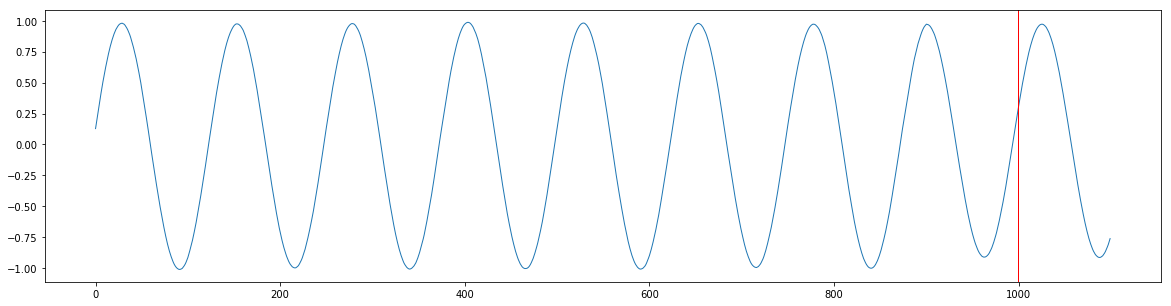

In [467]:
fig, ax = plt.subplots(figsize=(20, 5))

pd.Series(predictions_df[0].values.tolist()+predictions_df.loc[900].values[1:].tolist()).plot(
    kind='line',
    lw=1,
#     figsize=(20, 5),
    legend=False,
    ax=ax
);

ax.axvline(x=999, c='r', lw=1);

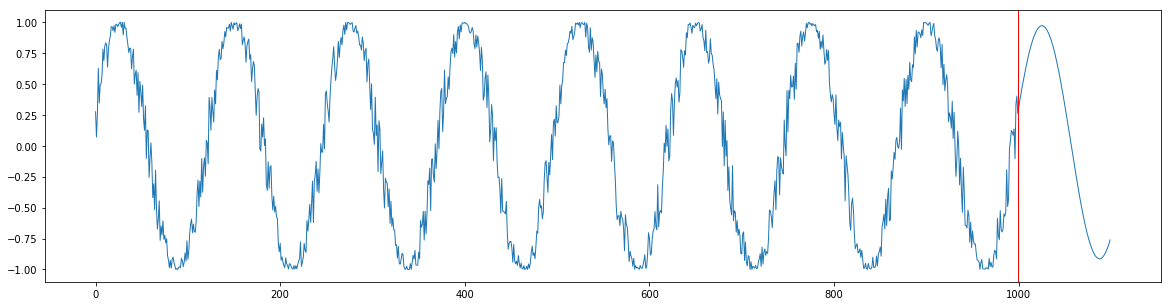

In [468]:
fig, ax = plt.subplots(figsize=(20, 5))

pd.Series(ts.tolist()+predictions_df.loc[900].values[100:].tolist()).plot(
    kind='line',
    lw=1,
#     figsize=(20, 5),
    ax=ax,
    legend=False
);

ax.axvline(x=999, c='r', lw=1);

### Summary

This seems to be a promising method. Worth investigating further

- It's curious that even with a lot of factors the forecasted values are very much de-noised
- I'm curious to see if this works well with time series that does not have as good of periodic behavior
- This can be used to forecast time series with missing values
  - Missing values would actually be imputed with this method
- Can generalize this method to forecasting multiple time series at once by using tensor factorization

# Downsampling for TDA using SVD

In [504]:
n_steps = 1000
rrand = 20
alpha = 0.6

ts = np.sin([(16*np.pi*x + rrand*random.random())/(n_steps) + alpha*random.random() for x in range(n_steps)])

pcld = time_series_to_point_cloud(time_series=np.array(ts), dimension_embed=2)

dm = distance_matrix(pcld, pcld)

In [505]:
dmx = dm.max()

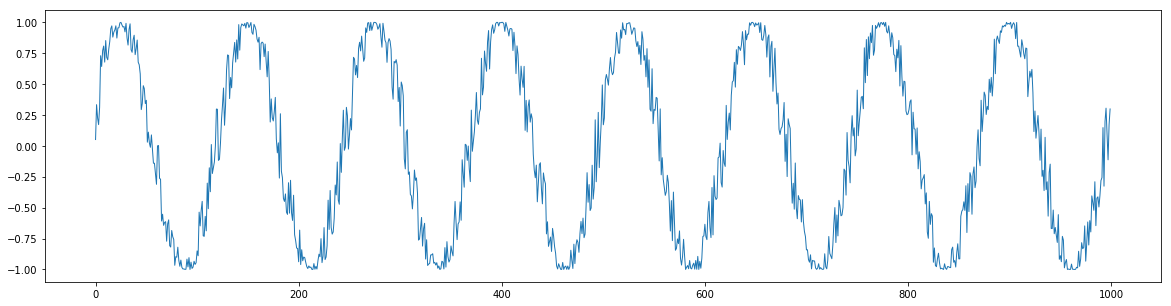

In [506]:
pd.DataFrame(ts).plot(
    kind='line',
    lw=1,
    figsize=(20, 5),
    legend=False
);

In [507]:
pcdf = pd.DataFrame(pcld)

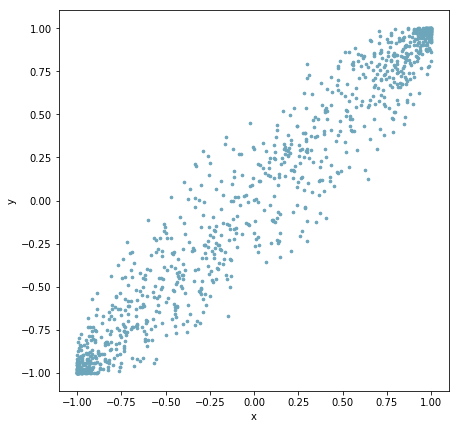

In [508]:
pcdf.rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7, 7),
    c='#6DA5BA',
    s=7
);

In [509]:
pcdf_stacked = pcdf.stack().to_frame().reset_index().rename(columns={
    'level_0': 'beginning_window_index',
    'level_1': 'step_index',
    0: 'value'
})

In [510]:
%%time

algo = SVD(
    n_factors=100,
    n_epochs=100,
    init_mean=0
)

reader = Reader(rating_scale=(-1, 1))

data = Dataset.load_from_df(
    df=pcdf_stacked[[
        'beginning_window_index',
        'step_index',
        'value'
    ]],
    reader=reader
)

CPU times: user 3.62 ms, sys: 96 µs, total: 3.71 ms
Wall time: 3.66 ms


In [511]:
train_set = data.build_full_trainset()

In [512]:
%%time

algo.fit(trainset=train_set)

CPU times: user 667 ms, sys: 1.58 ms, total: 668 ms
Wall time: 667 ms


In [513]:
test_set = train_set.build_testset()

In [514]:
%%time

predictions = algo.test(testset=test_set)

CPU times: user 19.1 ms, sys: 4.97 ms, total: 24.1 ms
Wall time: 19.4 ms


In [515]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.1159


0.11592051150885854

In [516]:
predictions_df = pd.DataFrame(predictions)

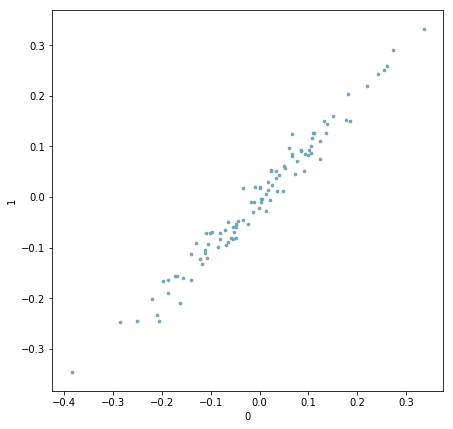

In [517]:
pd.DataFrame(algo.qi.T).plot(
    kind='scatter',
    x=0,
    y=1,
    figsize=(7, 7),
    c='#6DA5BA',
    s=7
);

In [540]:
n_pts = 10000
rrnd = 0.5
alpha = [0.4, 0.6, 0.2, 0.4]

pc = [[np.cos(x*np.pi) + alpha[0]*random.random(), np.sin(x*np.pi) + alpha[1]*random.random()] for 
      x in [(r + random.random()*rrnd)*(1/float(n_pts)) for r in range(-n_pts, n_pts)]]

In [541]:
pcdf = pd.DataFrame(pc)

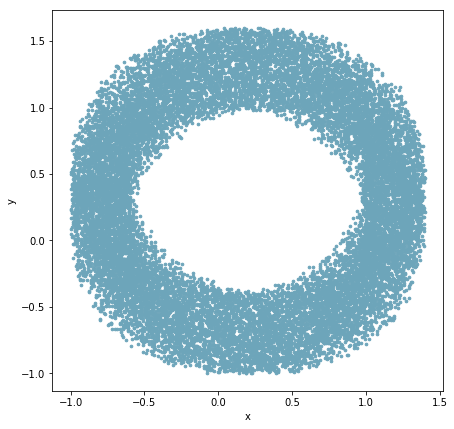

In [542]:
pcdf.rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7, 7),
    c='#6DA5BA',
    s=7
);

In [543]:
pcdf_stacked = pcdf.stack().to_frame().reset_index().rename(columns={
    'level_0': 'beginning_window_index',
    'level_1': 'step_index',
    0: 'value'
})

In [544]:
%%time

algo = SVD(
    n_factors=1000,
    n_epochs=100,
    init_mean=0
)

reader = Reader(rating_scale=(-1, 1))

data = Dataset.load_from_df(
    df=pcdf_stacked[[
        'beginning_window_index',
        'step_index',
        'value'
    ]],
    reader=reader
)

CPU times: user 147 ms, sys: 2.75 ms, total: 150 ms
Wall time: 148 ms


In [545]:
train_set = data.build_full_trainset()

In [546]:
%%time

algo.fit(trainset=train_set)

CPU times: user 2min 52s, sys: 274 ms, total: 2min 52s
Wall time: 2min 53s


In [547]:
test_set = train_set.build_testset()

In [548]:
%%time

predictions = algo.test(testset=test_set)

CPU times: user 419 ms, sys: 14.9 ms, total: 434 ms
Wall time: 428 ms


In [549]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.9691


0.96909355285380039

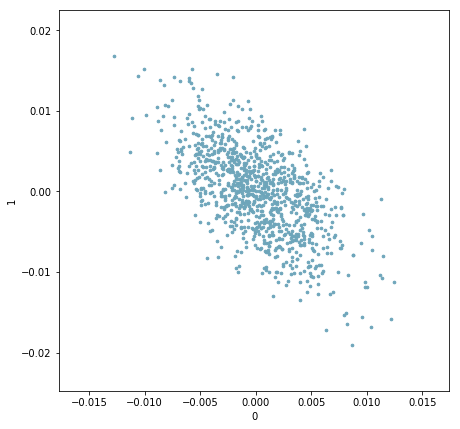

In [550]:
pd.DataFrame(algo.qi.T).plot(
    kind='scatter',
    x=0,
    y=1,
    figsize=(7, 7),
    c='#6DA5BA',
    s=7
);

### Summary

This did not turn out to be interesting. Not worth investigating further. This is not actually *downsampling*, just representing the "user" space with latent factors. It is not guaranteed to be a subsest, or even close, of the original users. The shape of the data is not in any way guaranteed to be the same shape after factorization.